In [ ]:
# Group Members: Abigail Amiscosa, Joshua Ibrom, Julian Spindola

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "tweets.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "vstepanenko/disaster-tweets",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-1106163941.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 656k/656k [00:00<00:00, 780kB/s]

Extracting zip of tweets.csv...
First 5 records:    id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Print some basic info to confirm
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

# Optional: peek at the first few rows
print("\nSample training data:")
print(train_df.head())

print("\nSample testing data:")
print(test_df.head())


Training set size: 9096
Testing set size: 2274

Sample training data:
          id   keyword           location  \
3912    3912   destroy                NaN   
5902    5902  flooding                NaN   
11305  11305  wreckage                NaN   
3691    3691  derailed         Pittsburgh   
11340  11340   wrecked  Oklahoma City, OK   

                                                    text  target  
3912   why the hell would want to join the Kenyan Cab...       0  
5902   Citizens United wreaked havoc on our democracy...       0  
11305  Through all the happiness and sorrow, I guess ...       0  
3691   Remember when this cheer derailed the campaign...       0  
11340  My first listen was also in the whip I damn ne...       0  

Sample testing data:
          id                keyword           location  \
3495    3495             demolished  Observation drone   
5461    5461               fatality                NaN   
9794    9794                   sunk             London   
111

In [ ]:
import re
import string
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords (only once)
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)                     # remove mentions
    text = re.sub(r"#\w+", "", text)                     # remove hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = text.lower()                                  # lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text.strip()

# Create the new 'clean_text' column
df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset shape: (11370, 7)

Columns: ['id', 'keyword', 'location', 'text', 'target', 'text_length', 'clean_text']

Missing values per column:
 id                0
keyword           0
location       3418
text              0
target            0
text_length       0
clean_text        0
dtype: int64

Class distribution:
 target
0    9256
1    2114
Name: count, dtype: int64


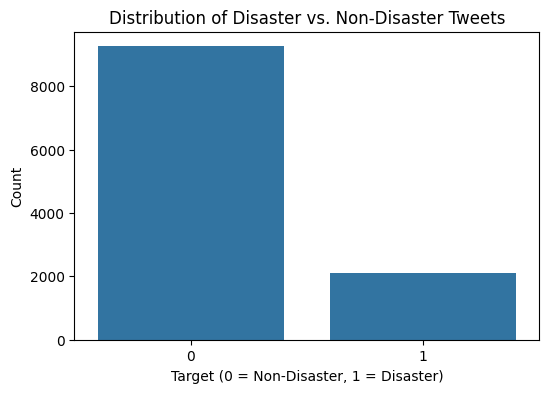

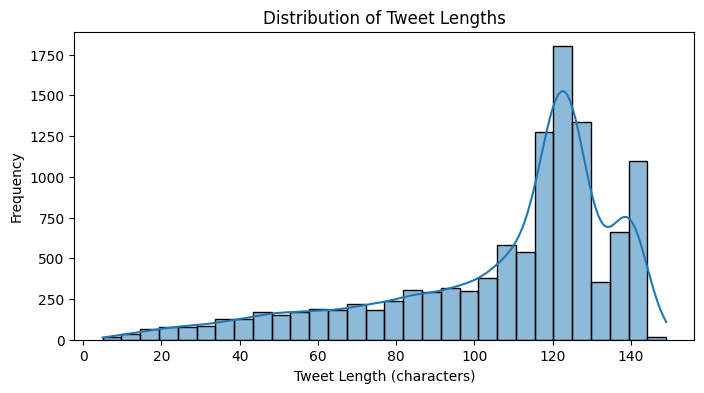

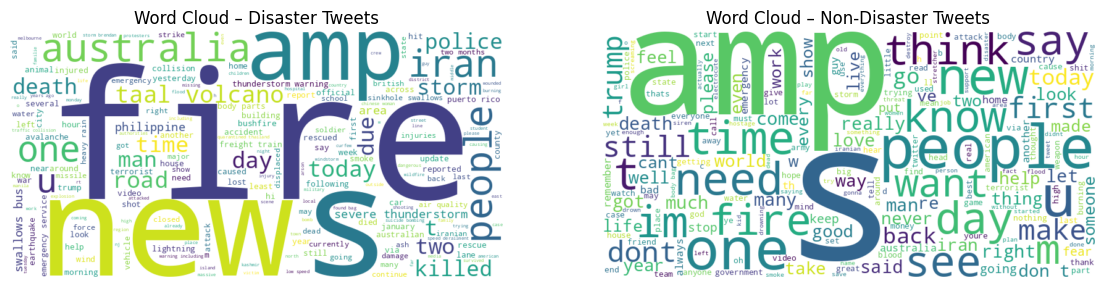

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Make sure your dataset is loaded
# Example: df = train_df or the original df

# Basic dataset overview
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nClass distribution:\n", df['target'].value_counts())

# Plot class distribution (0 = Not Disaster, 1 = Disaster)
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title("Distribution of Disaster vs. Non-Disaster Tweets")
plt.xlabel("Target (0 = Non-Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.show()

# Tweet length distribution
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Frequency")
plt.show()

# Most common words
disaster_words = " ".join(df[df['target'] == 1]['clean_text'])
nondisaster_words = " ".join(df[df['target'] == 0]['clean_text'])

# Generate word clouds
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_words)
wordcloud_non = WordCloud(width=800, height=400, background_color='white').generate(nondisaster_words)

# Show them side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(wordcloud_disaster, interpolation='bilinear')
axes[0].set_title("Word Cloud – Disaster Tweets")
axes[0].axis('off')

axes[1].imshow(wordcloud_non, interpolation='bilinear')
axes[1].set_title("Word Cloud – Non-Disaster Tweets")
axes[1].axis('off')

plt.show()


In [ ]:
# 1. Data Loading and Exploration

# Install dependencies if needed:
# pip install kagglehub[pandas-datasets] torch torchvision transformers scikit-learn bert-score matplotlib
# !pip install bert-score

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import string
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.optim import AdamW
from bert_score import score as bert_score

# Load dataset
file_path = "tweets.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "vstepanenko/disaster-tweets",
    file_path,
)

# print("First 5 records:")
# print(df.head())
# print("\nDataset info:")
# print(df.info())

/tmp/ipython-input-1656692512.py:27: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'disaster-tweets' dataset.
First 5 records:
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 no

In [ ]:
# 2. Text Preprocessing

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"#\w+", "", text)     # remove hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = text.lower().strip()
    return text

df["text"] = df["text"].astype(str).apply(clean_text)

In [ ]:
# 3. Feature Engineering & Vectorization

# Split data
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["target"], test_size=0.2, random_state=42)

# ---- CNN BASELINE (TF-IDF) ----
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train.tolist()).toarray()
X_test_tfidf = vectorizer.transform(X_test.tolist()).toarray()

X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

In [ ]:
# 4. Training - CNN Baseline

class CNNBaseline(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(16 * ((input_dim - 5 + 1)//2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

cnn_model = CNNBaseline(input_dim=X_train_tfidf.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(cnn_model.parameters(), lr=1e-3)

epochs = 3
cnn_model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[CNN] Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

# Evaluate CNN
cnn_model.eval()
y_pred_cnn = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = cnn_model(X_batch)
        y_pred_cnn.extend(torch.argmax(outputs, dim=1).cpu().numpy())

print("\n=== CNN Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cnn))
print("Precision:", precision_score(y_test, y_pred_cnn))
print("Recall:", recall_score(y_test, y_pred_cnn))
print("F1:", f1_score(y_test, y_pred_cnn))


[CNN] Epoch 1/3 - Loss: 0.5138
[CNN] Epoch 2/3 - Loss: 0.3342
[CNN] Epoch 3/3 - Loss: 0.2598

=== CNN Evaluation ===
Accuracy: 0.8931398416886543
Precision: 0.7428571428571429
Recall: 0.5909090909090909
F1: 0.6582278481012658


In [ ]:
# 5. Training - BERT Model (with Google Drive saving)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set checkpoint directory
import os
checkpoint_dir = "/content/drive/MyDrive/Disaster_BERT_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from bert_score import score as bert_score

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=64, return_tensors="pt")

train_encodings = tokenize(X_train.tolist())
test_encodings = tokenize(X_test.tolist())

train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(y_train.values)
)
test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
    torch.tensor(y_test.values)
)

train_loader_bert = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader_bert = DataLoader(test_dataset, batch_size=8)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

# Training
epochs = 2
best_f1 = 0.0

bert_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader_bert:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_bert)
    print(f"[BERT] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # Evaluate after epoch
    bert_model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader_bert:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    epoch_f1 = f1_score(trues, preds)
    print(f"Epoch {epoch+1} F1 Score: {epoch_f1:.4f}")

    # Save checkpoint to Drive
    save_path = os.path.join(checkpoint_dir, f"bert_checkpoint_epoch{epoch+1}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': bert_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, save_path)
    print(f"✅ Saved checkpoint to Google Drive: {save_path}")

    # Save best model
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_path = os.path.join(checkpoint_dir, "bert_best_model.pt")
        torch.save(bert_model.state_dict(), best_path)
        print(f"🌟 New best model saved at epoch {epoch+1} (F1={best_f1:.4f})")

    bert_model.train()

# Final evaluation
bert_model.eval()
preds, trues = [], []
with torch.no_grad():
    for batch in test_loader_bert:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        trues.extend(labels.cpu().numpy())

print("\n=== BERT Evaluation ===")
print("Accuracy:", accuracy_score(trues, preds))
print("Precision:", precision_score(trues, preds))
print("Recall:", recall_score(trues, preds))
print("F1:", f1_score(trues, preds))

# BERTScore (semantic similarity check)
P, R, F1_score_val = bert_score(X_test.tolist()[:50], X_test.tolist()[:50], lang="en", verbose=False)
print("\nBERTScore (self-similarity check):", F1_score_val.mean().item())

# Save final model and tokenizer to Drive
final_dir = os.path.join(checkpoint_dir, "bert_disaster_final")
bert_model.save_pretrained(final_dir)
tokenizer.save_pretrained(final_dir)
print(f"✅ Final fine-tuned BERT model and tokenizer saved to Google Drive at: {final_dir}")


Mounted at /content/drive


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT] Epoch 1/2 - Loss: 0.2796
Epoch 1 F1 Score: 0.7493
✅ Saved checkpoint to Google Drive: /content/drive/MyDrive/Disaster_BERT_Checkpoints/bert_checkpoint_epoch1.pt
🌟 New best model saved at epoch 1 (F1=0.7493)
[BERT] Epoch 2/2 - Loss: 0.1461
Epoch 2 F1 Score: 0.7669
✅ Saved checkpoint to Google Drive: /content/drive/MyDrive/Disaster_BERT_Checkpoints/bert_checkpoint_epoch2.pt
🌟 New best model saved at epoch 2 (F1=0.7669)

=== BERT Evaluation ===
Accuracy: 0.9243623570800352
Precision: 0.827485380116959
Recall: 0.7146464646464646
F1: 0.7669376693766937


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore (self-similarity check): 1.0
✅ Final fine-tuned BERT model and tokenizer saved to Google Drive at: /content/drive/MyDrive/Disaster_BERT_Checkpoints/bert_disaster_final


In [ ]:
# 5. BERTScore Evaluation

P, R, F1 = bert_score(list(X_test), list(X_test), lang="en", verbose=True)
print(f"\n[BERTScore] Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/36 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/36 [00:00<?, ?it/s]

done in 792.09 seconds, 2.87 sentences/sec

[BERTScore] Precision: 1.0000, Recall: 1.0000, F1: 1.0000
